In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import words, wordnet
import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt

### Resources
- [WordNet](https://wordnet.princeton.edu/)
    - [youtube tut](https://www.youtube.com/watch?v=T68P5-8tM-Y)
- [OPTED](http://www.mso.anu.edu.au/~ralph/OPTED/)
- [wordlist](http://wordlist.aspell.net/)

Inspiration:
- https://en.wikipedia.org/wiki/Combinatorics_on_words
    check out Thue's work

# Loading, preprocessing

Exclusion conditions:

- contains numbers or symbols (what about hyphens?)
    - Yes, some real words contain hyphens but for now let's focus on "pure" words without special symbols
    
- is an acronym
    
- contains a capital letter not at start of word
 
- is straight up just not a word in the english dictionary (how to check this?)
    - I want to remove names and cities (why tf are they in dictionaries in the first place??)
        - Can't I just filter by if it starts with a capital word?
    - Need to find a corpus with definitions and parts of speech
    

NLTK corpora

In [242]:
#contains most words... missing some past tense, like "argued", wtf?
manywords = words.words() + list(wordnet.words())
manywords = list(dict.fromkeys(manywords)) #remove duplicates
len(manywords)

331327

Other corpora

In [33]:
#I totally forgot and didn't document where 'all_words.txt' came from
df = pd.read_csv('all_words.txt', sep=' ', header=None) #just words
#df2 = pd.read_csv('oed.txt', sep=' ', header=None) #Oxford Eng Dict, broken import

So we don't want numbers, but some real words have them (e.g. catch-22) so what to do? 

In [239]:
# some functions to search words for undesirable properties

def has_undesirable(inputStr):
    total_bool = bool(re.search(r'\d', inputStr)) or any(not c.isalnum() for c in inputStr) or any(c.isupper() for c in inputStr)
    return total_bool
        

In [243]:
manywords = [i for i in manywords if has_undesirable(i) == False]
len(manywords)

236325

# Algorithm, Analysis

So my initial idea was to calculate hamming distance of words with one another, and coming back to this I am interested in creating the partitions for symbolic dynamics state space.  But those aren't mutually exclusive and can both help construct state graph.

Creating dynamics graph:
- for each word in corpus, split it into constituent letters
- then define it as edges on a graph: e.g. for word graph: g->r->a->p->h becomes {(g,r),(r,a),(a,p),(p,h)}
- Construct the entire graph of the english language this way.
    - Starting condition is all 26 letters as disjoint nodes
    - Append an edge to a letter connecting to a new node 
    - Is revisiting a letter a cycle or a new node? (e.g. aardvark
    - Might have to tweak the rules a bit to avoid redundancies

Hamming Rules (?):
- Replace letters alphabetically and in quantity until possibilities exhausted, then add the next letter. 

Analysis:
- Under what conditions does non skipping occur? (steps of size 1)
- Note statistical properties of letters
     - Like what other letters typically trail, 
- See where switches occur eg "dating" vs "duties"
- HAMMING DISTANCE
- Observe nonlinear properties
- What do the outskirts of the graph look like

Further questions:
- What do the graphs and properties look like for contextually restricted texts, like essays and books?
    - more homogeneity in words and their semantic properties
- Semantic clustering
- How to incoporate tenses?  (Should word list passed just include the word or all its tenses too?  What happens when you switch from one to the other?)
    - compare graphs with and without tenses



In [ ]:
#from wikipedia
def hamming_distance(s1, s2) -> int:
    """Return the Hamming distance between equal-length sequences."""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length.")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

In [245]:
word_chars = []
for i in manywords: 
    word_chars.append(list(i))

def gen_word_graphs(corpus, mode = 'acyclic'):
    word_edges = []
    for word in corpus:
        edge_list = []
        for n_i, i in enumerate(word):
            try:
                if mode == 'acyclic':
                    edge_list.append((word[n_i] + str(n_i), word[n_i+1] + str(n_i+1)))
                else:
                    edge_list.append((word[n_i], word[n_i+1]))
            except IndexError:
                break

        word_edges.append(edge_list)
        
    return [x for x in word_edges if x != []]

In [246]:
word_edges = gen_word_graphs(manywords)

notice that single words ("a", or "I") don't appear in word_edges because they are single nodes.  Does this matter? (probably not, until I find a way to incorporate stop conditions, which is which letter to stop at)

Now we initialize the starting nodes (the first letter of a word) which are disjoint, since if one pointed to the other, the latter would no longer be a starting node.

### Analysis
Could be interesting to compare degrees of these, and then for each next "layer" of nodes (high dimensional so layers are not well defined)
   - Degrees for most starting points will most likely be around 20-26
   - Will decrease as you move up
   - Degree one when you are on the path of a unique word
   - in-degree vs out-degree?
   - Vowels vs consonants?  (and are patterns between the two consistent across languages?)
   
When do we see discontinuities for letters at certain layers?  E.g. there is no z20 but there is a z22
   
Also want to see distribution of letter layers and layers: (i.e. how many z10's are there vs b10?  What is the highest layer number and which letters occupy that?)

Algorithm:
1. Go through each element of word_edges.  If you encounter a new edge (e.g. ('a','a'), append to graph.  If you encounter it again, skip. 
2.  Once you've gone through index 0 of each word, now go through the next and repeat.

Cyclical version: layer doesn't matter.  The state space would be partitioned into 26.  There can be loops.  
   - Information loss (e.g. don't know if to repeat 3 times) without knowledge of dynamics
   
Acyclic version: layer matters, can have "repeated" nodes (though layer ID would differ). 

In [371]:
#might delete later
start_nodes = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
               'n','o','p','q','r','s','t','u','v','w','x','y','z']

In [ ]:
def gen_master_graph(edges):
    """
    Creates a connected digraph based on an input of allowed edges.  
    With this graph you can create any word by following edges.
    """
    master_graph = []
    for word in edges:
        for edge in word:
            if edge not in master_graph:
                master_graph.append(edge)
    return master_graph

In [ ]:
master_graph = gen_master_graph(word_edges)
len(master_graph)

Updated preprocessing pruned 10k of the edges!

In [279]:
len(master_graph)

7162

In [262]:
np_master = np.array(master_graph)

In [270]:
def edges_at_n(corpus_graph, node, pos = 'in'):
    """
    returns edges that start or end with a given node 
    note: the length of the array when pos == 'in' is the same as the out degree, and vice versa 
    """
    if pos == 'in':
        index = 0
    elif pos == 'out':
        index = 1
    np_master = np.array(corpus_graph)
    loc_arr = np.where(np_master[:,index] == node)
    edges = []
    for i in loc_arr[0]:
        edges.append(corpus_graph[i])
    return edges

In [271]:
x = edges_at_n(master_graph, 'b3', pos = 'out')
x

[('o2', 'b3'),
 ('s2', 'b3'),
 ('e2', 'b3'),
 ('a2', 'b3'),
 ('r2', 'b3'),
 ('i2', 'b3'),
 ('l2', 'b3'),
 ('u2', 'b3'),
 ('y2', 'b3'),
 ('m2', 'b3'),
 ('n2', 'b3'),
 ('h2', 'b3'),
 ('b2', 'b3'),
 ('c2', 'b3'),
 ('w2', 'b3'),
 ('d2', 'b3'),
 ('g2', 'b3'),
 ('t2', 'b3'),
 ('x2', 'b3'),
 ('p2', 'b3'),
 ('k2', 'b3'),
 ('f2', 'b3'),
 ('j2', 'b3'),
 ('z2', 'b3')]

Based on this observation, want to expunge words with numbers... Cause who tf puts "a_1" in a corpus of words

In [266]:
G = nx.DiGraph(master_graph)

In [269]:
G.out_degree['b3']

23

In [278]:
len(list(G.nodes))

560

as of 5/18/20, current size of the corpus is 236,325 (google says the Oxford English Dictionary contains full entries for 171,476 words in current use; 47,156 of which are obsolete words).  The current master graph for the corpus contains 560 nodes, and 7,162 edges.  Which is pretty cool.  So I wonder how close this is to the real statistics, given a "pure" corpus of the english language, excluding tenses.  

From earlier: A little sus that there is even a word whose 21st letter is z.  So want to make a function that shows list of words where a given index is a certain letter.  

Why does degree change when changing to a digraph?  e.g for z20 it went from 27 to 13??

In [187]:
def words_at_n(corpus, letter, pos):
    """
    returns list of words where a given index is a certain letter
    """
    targets = []
    for word in corpus:
        try:
            if word[pos] == letter:
                targets.append(word)
        except IndexError:
            continue
    return targets

Would be interesting to see statistics of this function for varying the letters and positions

Also some of these words may not exist? E.g. those with z @ index 18: 'counterrevolutionize', 'disdenominationalize'

In [321]:
words_at_n(manywords, 'e', 29)

['chlorobenzylidenemalononitrile']

### Functions to make

- One that checks whether given [consecutive] edges form an existing word, and then using it to identify which nodes can be stopping points.
    - or backwards, given a word create those edges
- Graph stats regarding its nodes
    - longest word, and where it stands relative to other words
    - Distribution of degree in the overall graph
        - Also, given a word, show degree, in degree, and out degree of each of those nodes 
    - Compare letters vs layers 
        - see where discontinuities in layers occur (no z20 for example)
    
- How can this graph be partitioned?

In [344]:
class LanguageGraphStats:
    def __init__(self, master_graph, mode = 'digraph'):
        """
        
        """
        if mode == 'digraph':
            self.nx_graph = nx.DiGraph(master_graph)
        else:
            self.nx_graph = nx.Graph(master_graph)
            
        self.nodes = list(self.nx_graph.nodes)
        self.edges = master_graph
        self.layers = [int(i[1:]) for i in self.nodes]
        
    def getSize(self, part = None):
        if part == 'nodes':
            return len(self.nodes)
        elif part == 'edges':
            return len(self.edges)
        elif part == 'layers':
            return max(self.layers)
    
    def eltsAtPartition(self, fix = None):
        """
        Graph nodes can be split up into a partition of layer number or letters
        Returns elements at fix: a certain fixed layer number, or letter.  
        E.g. 10--> a10, b10, etc.   'n' --> 0,1,2,3, etc.
        
        This is where words_at_n comes in useful to investigate edge cases
        
        """
        elt_arr = []
        for i in self.nodes:
            if type(fix) == int:
                if i[1:] == str(fix): 
                    elt_arr.append(i)
                    elt_arr.sort()
            elif type(fix) == str:
                if i[0] == fix:
                    elt_arr.append(i)
                    elt_arr = sorted(elt_arr, key=lambda x: float(x[1:]))
        return elt_arr

In [345]:
test = LanguageGraphStats(master_graph)

In [346]:
test.getSize('edges')

7162

In [379]:
z = test.eltsAtPartition('a')
z

['a0',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'a9',
 'a10',
 'a11',
 'a12',
 'a13',
 'a14',
 'a15',
 'a16',
 'a17',
 'a18',
 'a19',
 'a20',
 'a21',
 'a22',
 'a23',
 'a24',
 'a28']

In [372]:
num_letters_at_layer = [len(test.eltsAtPartition(i)) for i in range(30+1)]
num_layers_at_letter = [len(test.eltsAtPartition(i)) for i in start_nodes]

<BarContainer object of 26 artists>

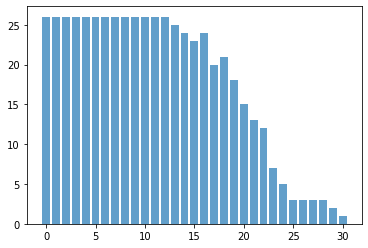

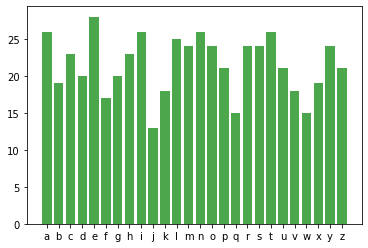

In [383]:
plt.figure()
plt.bar(range(31), num_letters_at_layer, alpha = 0.7)
plt.figure()
plt.bar(start_nodes, num_layers_at_letter, color = 'green', alpha = 0.7)
